**NAME** - _Padmanavan Kumar_

**Anomaly Detection in Network Traffic**

Using unsupervised learning techniques such as _isolation forests_ or _autoencoders_ to detect unusual patterns or anomalies in network traffic data, which could indicate potential security breaches or system malfunctions.

Resources :

https://www.kaggle.com/datasets/galaxyh/kdd-cup-1999-data

c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8799 - val_loss: 0.6658
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6427 - val_loss: 0.6098
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5853 - val_loss: 0.5956
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6070 - val_loss: 0.5887
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6634 - val_loss: 0.5852
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5918 - val_loss: 0.5831
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5368 - val_loss: 0.5817
Epoch 8/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5938 - val_loss: 0.5808
Epoch 9/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5455 - val_loss: 0.5801
Epoch 10/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5194 - val_loss: 0.5796
Epoch 11/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5072 - val_loss: 0.5791
Epoch 12/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

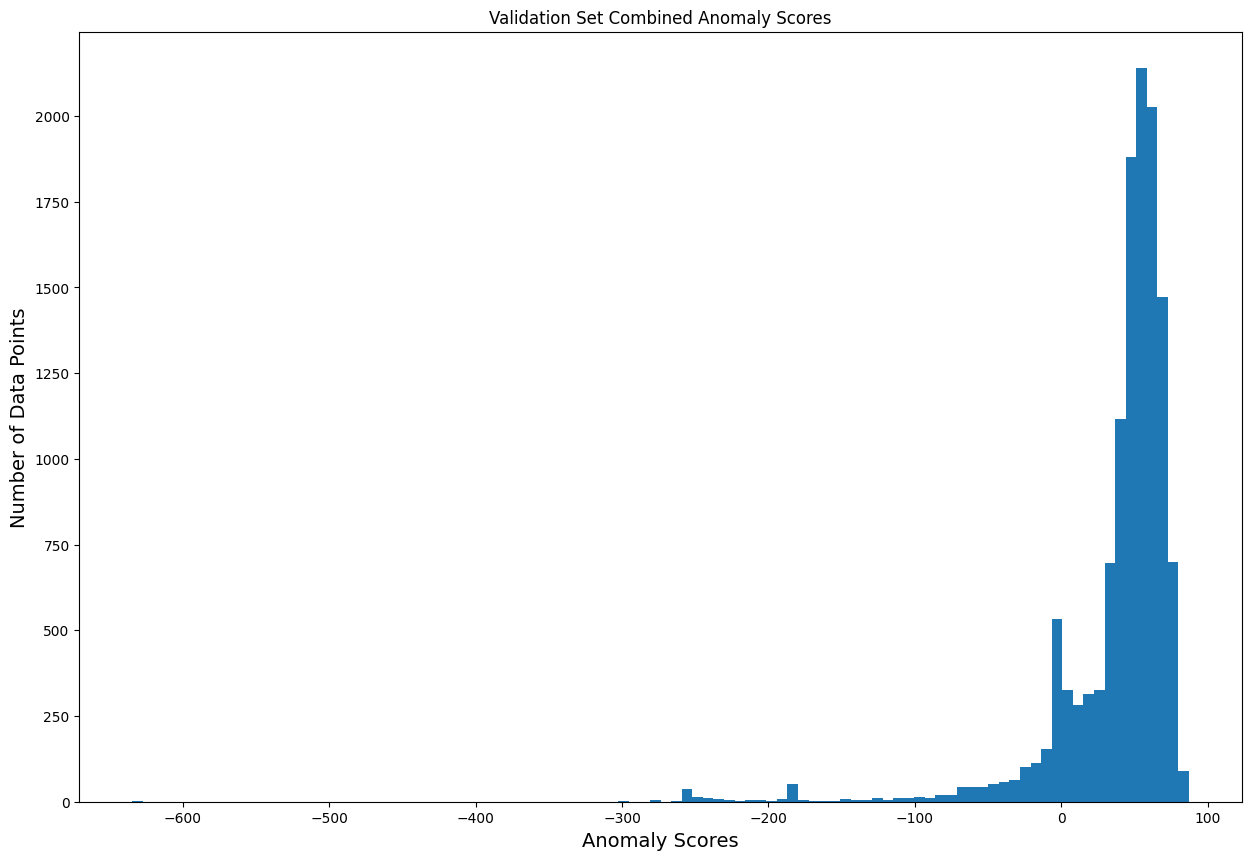

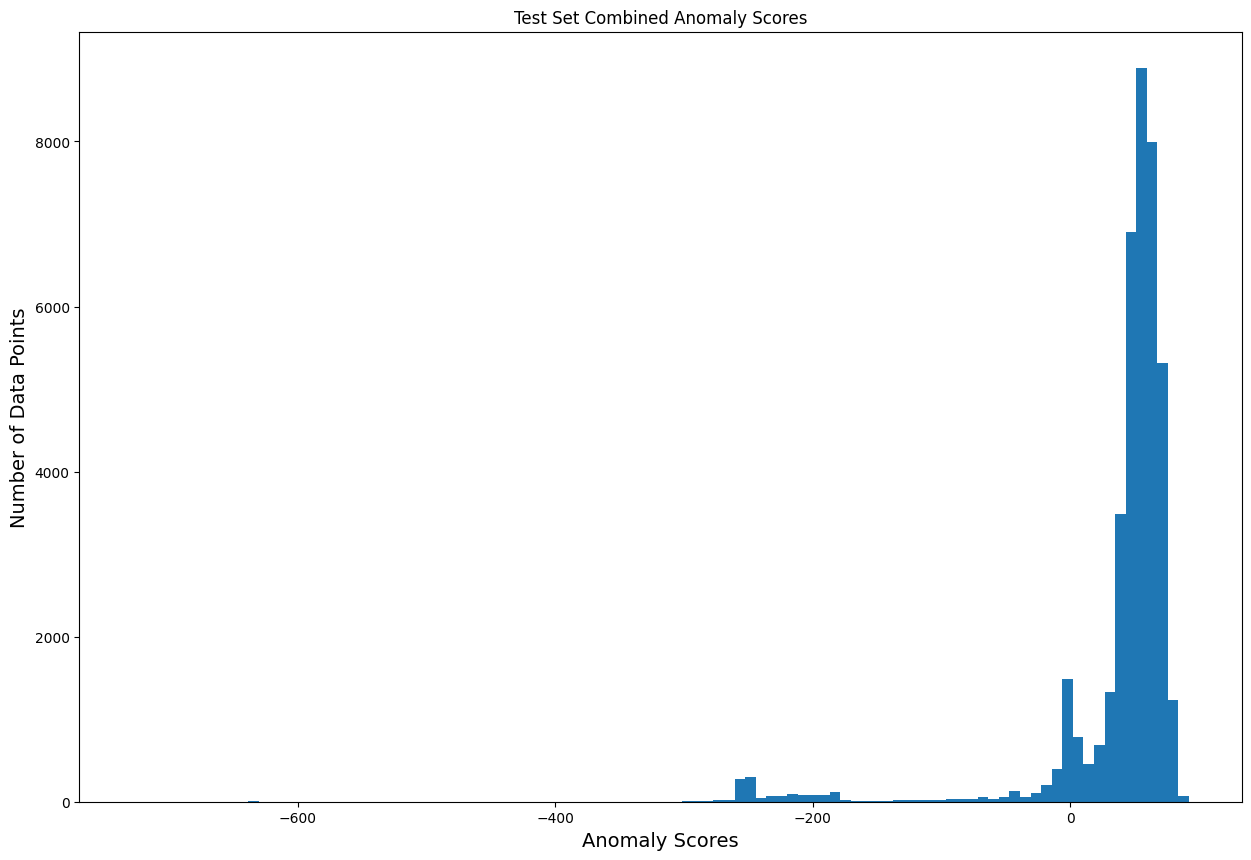

Validation AUC: 93.64%
Test AUC: 97.63%


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the data
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment",
    "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

df = pd.read_csv('kddcup.data_10_percent_corrected', header=None, names=column_names)
df_test = pd.read_csv('corrected', header=None, names=column_names)

# Filter data to only include HTTP service and drop the service column
df = df[df["service"] == "http"].drop("service", axis=1)
df_test = df_test[df_test["service"] == "http"].drop("service", axis=1)

# Combine training and test data for label encoding
combined_data = pd.concat([df, df_test], axis=0)

# Encode categorical variables
label_encoders = {}
for col in combined_data.columns:
    if combined_data[col].dtype == 'object':
        le = LabelEncoder()
        combined_data[col] = le.fit_transform(combined_data[col])
        df[col] = le.transform(df[col])
        df_test[col] = le.transform(df_test[col])
        label_encoders[col] = le

# Shuffle and split data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

x_train = df_train.drop("label", axis=1)
y_train = df_train["label"]
x_val = df_val.drop("label", axis=1)
y_val = df_val["label"]
x_test = df_test.drop("label", axis=1)
y_test = df_test["label"]

# Normalize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# Model 1: Isolation Forest
iso_forest = IsolationForest(
    n_estimators=1000, 
    max_samples=0.8, 
    contamination=0.05, 
    random_state=42,
    n_jobs=-1
)
iso_forest.fit(x_train)
anomaly_scores_iso_val = iso_forest.decision_function(x_val)
anomaly_scores_iso_test = iso_forest.decision_function(x_test)

# Model 2: One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
ocsvm.fit(x_train)
anomaly_scores_ocsvm_val = ocsvm.decision_function(x_val)
anomaly_scores_ocsvm_test = ocsvm.decision_function(x_test)

# Model 3: Autoencoder
input_dim = x_train.shape[1]
encoding_dim = 14

autoencoder = Sequential([
    Dense(encoding_dim, activation="relu", input_shape=(input_dim,)),
    Dropout(0.2),
    Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_val, x_val), verbose=1)

# Autoencoder Anomaly Scores
reconstructions_val = autoencoder.predict(x_val)
mse_val = np.mean(np.power(x_val - reconstructions_val, 2), axis=1)
anomaly_scores_auto_val = -mse_val

reconstructions_test = autoencoder.predict(x_test)
mse_test = np.mean(np.power(x_test - reconstructions_test, 2), axis=1)
anomaly_scores_auto_test = -mse_test

# Ensemble Model: Weighted Average of Anomaly Scores
val_scores_combined = 0.4 * anomaly_scores_iso_val + 0.3 * anomaly_scores_ocsvm_val + 0.3 * anomaly_scores_auto_val
test_scores_combined = 0.4 * anomaly_scores_iso_test + 0.3 * anomaly_scores_ocsvm_test + 0.3 * anomaly_scores_auto_test

# Plot Histograms
def plot_histogram(anomaly_scores, title):
    plt.figure(figsize=(15, 10))
    plt.hist(anomaly_scores, bins=100)
    plt.xlabel('Anomaly Scores', fontsize=14)
    plt.ylabel('Number of Data Points', fontsize=14)
    plt.title(title)
    plt.show()

plot_histogram(val_scores_combined, 'Validation Set Combined Anomaly Scores')
plot_histogram(test_scores_combined, 'Test Set Combined Anomaly Scores')

# Calculate AUC for Validation Set
auc_val_combined = roc_auc_score(y_val == label_encoders["label"].transform(["normal."])[0], val_scores_combined)
print(f"Validation AUC: {auc_val_combined:.2%}")

# Calculate AUC for Test Set
auc_test_combined = roc_auc_score(y_test == label_encoders["label"].transform(["normal."])[0], test_scores_combined)
print(f"Test AUC: {auc_test_combined:.2%}")
